In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [5]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/refs/heads/main/data/Fake.csv')

In [6]:
fake

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...         News   
3      On Christmas day, Donald Trump announced that ...         News   
4      Pope Francis used his annual Christmas Day mes...         News   
...                                                  ...          ...   
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                    date  
0      December 31, 2017  
1      December 31, 2017  
2      December 30, 2017  
3      December 29, 2017  
4      December 25, 2017  
...                  ...  
23476   January 16, 2016  
23477   January 16, 2016  
23478   January 15, 2016  
23479   January 14, 2016  
23480   January 12, 2016  

[23481 rows x 4 columns]

In [7]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [8]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

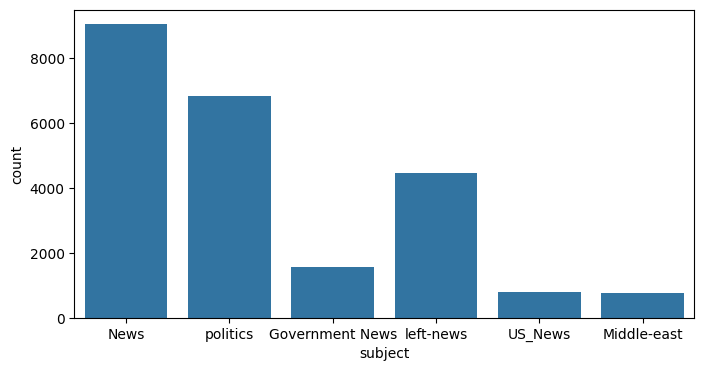

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x = 'subject' ,data=fake)

In [10]:
text = ' '.join(fake['text'].tolist())

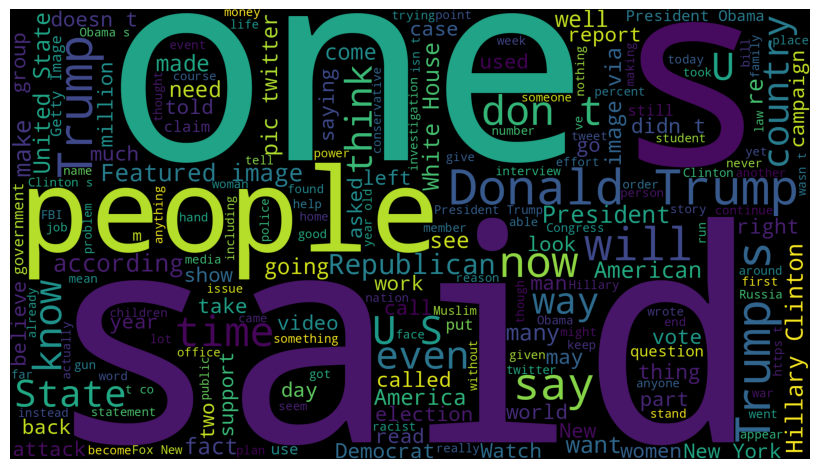

In [11]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [12]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/refs/heads/main/data/True.csv')

In [13]:
text = ' '.join(real['text'].tolist())

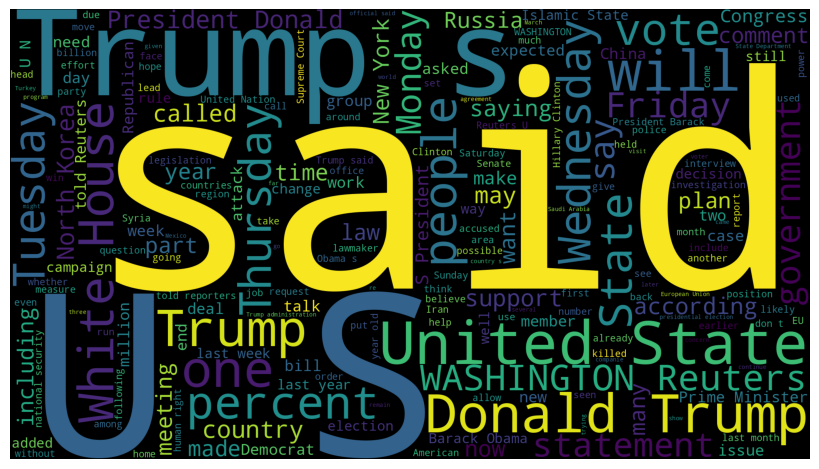

In [14]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [15]:
real.sample(5)

title  \
21370    Finnish police release one knife attack suspect   
8165   Kremlin: Obama's Trump criticism anti-Russian,...   
14078  Iran Guards ready to help rebuild Syria, Hezbo...   
7757   U.S. partnership with Turkey in Islamic State ...   
13467  Turkey's Halkbank denies allegations of illega...   

                                                    text       subject  \
21370  HELSINKI (Reuters) - Finnish police on Thursda...     worldnews   
8165   MOSCOW (Reuters) - The Kremlin said on Wednesd...  politicsNews   
14078  ANKARA (Reuters) - Iran s Revolutionary Guards...     worldnews   
7757   WASHINGTON (Reuters) - The U.S. partnership wi...  politicsNews   
13467  ISTANBUL (Reuters) - Turkish state lender Halk...     worldnews   

                      date  
21370     August 24, 2017   
8165   September 14, 2016   
14078   November 23, 2017   
7757     October 20, 2016   
13467   November 30, 2017

In [16]:
unknown_publisher = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-',maxsplit=1)
    record[1]

    assert (len(record[0])<120)
  except:
    unknown_publisher.append(index)

In [17]:
len(unknown_publisher)

222

In [18]:
real.iloc[unknown_publisher].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [19]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [20]:
real = real.drop(8970, axis=0)

In [21]:
publisher = []
tmp_text = []

for index, row in enumerate(real.text.values):
  if index  in unknown_publisher:
    tmp_text.append(row)
    publisher.append('Unknown')

  else:
    record = row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [22]:
real['publisher'] = publisher
real['text'] = tmp_text

In [23]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S. Post...  politicsNews   

                 date                     publisher  
0  December 31, 2017           WASHINGTON (Reuters)  
1  December 29, 2017           WASHINGTON (Reuters)  
2  December 31, 2017           WASHINGTON (Reuters)  
3  December 30, 2017           WASHINGTON (Reuters)  
4  December 29, 2017   SEATTLE/WASHINGTON (Reuters)

In [24]:
real.shape

(21416, 5)

In [25]:
empty_fake_index = [index for index,text in enumerate (fake.text.tolist()) if str(text).strip()=="" ]

In [26]:
fake.iloc[empty_fake_index]

title text    subject  \
10923  TAKE OUR POLL: Who Do You Think President Trum...        politics   
11041  Joe Scarborough BERATES Mika Brzezinski Over “...        politics   
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...        politics   
11225  MAYOR OF SANCTUARY CITY: Trump Trying To Make ...        politics   
11236  SHOCKER: Public School Turns Computer Lab Into...        politics   
...                                                  ...  ...        ...   
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...       left-news   
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...       left-news   
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...       left-news   
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...       left-news   
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...       left-news   

               date  
10923  May 10, 2017  
11041  Apr 26, 2017  
11190   Apr 6, 2017  
11225   Apr 2, 2017  
11236   Apr 1, 2017  
...             ...  
21816  Apr 27, 2015  
21826  Apr 25, 2015  
21827  Apr 25, 2015  
21857  Apr 14, 2015  
21873  Apr 12, 2015  

[630 rows x 4 columns]

In [27]:
real['text'] = real['title'] +" "+ real['text']
fake['text'] = fake['title'] +" "+ fake['text']

In [28]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

In [29]:
real['text']

0        as u.s. budget fight looms, republicans flip t...
1        u.s. military to accept transgender recruits o...
2        senior u.s. republican senator: 'let mr. muell...
3        fbi russia probe helped by australian diplomat...
4        trump wants postal service to charge 'much mor...
                               ...                        
21412    'fully committed' nato backs new u.s. approach...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy $1.14 billion worth of russia...
Name: text, Length: 21416, dtype: object

In [30]:
real['class'] = 1
fake['class'] = 0

In [31]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [32]:
real = real[['text','class']]
fake = fake[['text','class']]

In [33]:
data = pd.concat([real, fake], ignore_index=True)

In [34]:
data.sample(5)

text  class
17715  joint strike fighter plans stolen in australia...      1
23217   is nothing sacred? ivanka trump’s passover fa...      0
6015   senate republicans signal strong support for s...      1
28593   a massive screw up may have just cost trump t...      0
43122  veterans can’t get health care…but these mn so...      0

In [35]:
!pip install spacy==3.7.6
!python -m spacy download en_core_web_sm==3.7.1
!pip install nltk==3.9.1
!pip install beautifulsoup4==3.2.2
!pip install textblob==0.18.0.post0
!pip install googletrans==3.1.0a0
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

Reason for being yanked: Incorrect compatibility for transformer models
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5

✘ No compatible package found for 'en_core_web_sm==3.7.1' (spaCy
v3.7.6)

ERROR: Could not find a version that satisfies the requirement beautifulsoup4==3.2.2 (from versions: 4.0.1, 4.0.2, 4.0.3, 4.0.4, 4.0.5, 4.1.0, 4.1.1, 4.1.2, 4.1.3, 4.2.0, 4.2.1, 4.3.0, 4.3.1, 4.3.2, 4.4.0, 4.4.1, 4.5.0, 4.5.1, 4.5.2, 4.5.3, 4.6.0, 4.6.1, 4.6.2, 4.6.3, 4.7.0, 4.7.1, 4.8.0, 4.8.1, 4.8.2, 4.9.0, 4.9.1, 4.9.2, 4.9.3, 4.10.0, 4.11.0, 4.11.1, 4.11.2, 4.12.0, 4.12.1, 4.12.2, 4.12.3, 4.13.0b2)
ERROR: No matching distribution found for beautifulsoup4==3.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-2410dtel
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-2410dtel
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 0f56a6502679f6750b7f0ffed98f590d1f0246bd
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess_kgptalkie: filename=preprocess_kgptalkie-0.11-py3-none-any.whl size=8175 sha256=d4582f7f6d69f135d95178a376c250129ad0a5f738af601f92a3218c7e4fcd26
  Stored in directory: /tmp/pip-ephem-wheel-cache-lqaxm5r_/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess_kgptalkie


In [36]:
import preprocess_kgptalkie as ps

In [37]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [38]:
import gensim

In [39]:
y = data['class'].values

In [40]:
X = [d.split() for d in data['text'].tolist()]

In [41]:
type(X[0])

list

In [42]:
print(X[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [43]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [44]:
len(w2v_model.wv.key_to_index)

230854

In [45]:
w2v_model.wv['love']

array([ 3.21659589e+00,  4.44795460e-01, -1.27652287e+00, -7.28320181e-01,
       -3.35316801e+00,  7.43933201e-01,  1.00209951e+00,  1.52331817e+00,
       -1.30845904e-01,  4.47019672e+00, -1.00073226e-01, -4.21808910e+00,
       -2.39511800e+00, -1.69565451e+00, -1.09225953e+00, -1.17463112e-01,
       -6.95865691e-01,  1.38982308e+00,  1.21102319e-03,  9.53709364e-01,
       -2.92044306e+00, -1.58283436e+00, -2.14420295e+00,  3.78001690e+00,
       -1.51864517e+00,  5.26809168e+00,  7.76681423e-01,  3.04989398e-01,
        5.01791000e-01,  1.93423510e-01,  4.75114679e+00, -1.99097955e+00,
       -3.05699229e-01,  4.59901750e-01, -2.36653090e+00,  2.91889715e+00,
        7.34765530e-01, -9.56907630e-01,  5.42685628e-01, -3.66878104e+00,
        2.16253304e+00, -5.30743551e+00, -3.64609718e+00, -1.68686378e+00,
       -2.25878072e+00, -1.77308142e-01,  1.80606306e+00, -2.25927782e+00,
       -8.15162838e-01,  5.61094940e-01, -4.18354988e-01,  1.32170987e+00,
        3.54005790e+00, -

In [46]:
w2v_model.wv.most_similar('love')

[('thank', 0.7072433233261108),
 ('applaud', 0.6842234134674072),
 ('appreciate', 0.6620029807090759),
 ('pray', 0.6438218951225281),
 ('wish', 0.6430346965789795),
 ('admire', 0.6355715394020081),
 ('beautiful', 0.619888424873352),
 ('bless', 0.617085874080658),
 ('prayed', 0.6118776202201843),
 ('wonderful', 0.6118597984313965)]

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [48]:
X = tokenizer.texts_to_sequences(X)

In [49]:
X

[[18,
  30,
  473,
  481,
  10670,
  133,
  8090,
  40,
  1375,
  5171,
  1,
  419,
  3,
  4,
  301,
  79,
  6312,
  6,
  1,
  30,
  189,
  29,
  774,
  26,
  279,
  9,
  4,
  1107,
  2958,
  3,
  1,
  124,
  953,
  2,
  448,
  9,
  184,
  1193,
  173,
  393,
  4,
  1375,
  301,
  8,
  342,
  5,
  1109,
  473,
  7805,
  6,
  1188,
  6,
  1764,
  16,
  4,
  3407,
  7896,
  141,
  164,
  320,
  133,
  30,
  798,
  921,
  7806,
  675,
  8,
  2010,
  476,
  1,
  383,
  1761,
  4,
  559,
  589,
  8,
  168,
  691,
  50,
  408,
  28,
  17341,
  2,
  89,
  1352,
  65,
  6,
  410,
  60,
  32,
  776,
  25,
  1,
  8091,
  8,
  203,
  408,
  39,
  1438,
  350,
  2,
  929,
  4,
  168,
  473,
  6,
  4,
  481,
  304,
  2,
  22,
  1957,
  2,
  80,
  426,
  170,
  18,
  312,
  208,
  107,
  18,
  1,
  515,
  570,
  96,
  1779,
  1503,
  6,
  50,
  133,
  39,
  1072,
  2,
  377,
  349,
  3,
  189,
  37,
  68,
  14,
  5,
  19,
  133,
  182,
  4,
  379,
  473,
  959,
  6,
  169,
  691,
  110,
  196,
  62,

In [50]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

In [51]:
# Number of words in each row

[len(x) for x  in X]

[753,
 628,
 464,
 382,
 860,
 599,
 543,
 139,
 103,
 74,
 404,
 623,
 104,
 188,
 359,
 450,
 697,
 181,
 394,
 218,
 527,
 910,
 415,
 364,
 693,
 375,
 350,
 270,
 75,
 434,
 177,
 228,
 95,
 337,
 1113,
 839,
 554,
 469,
 466,
 99,
 180,
 324,
 582,
 72,
 409,
 365,
 617,
 358,
 85,
 403,
 81,
 962,
 656,
 418,
 399,
 384,
 220,
 162,
 389,
 616,
 489,
 244,
 849,
 370,
 628,
 649,
 1302,
 430,
 398,
 142,
 214,
 1108,
 75,
 74,
 588,
 850,
 758,
 788,
 347,
 694,
 482,
 416,
 84,
 419,
 127,
 1383,
 100,
 458,
 358,
 85,
 62,
 108,
 656,
 350,
 228,
 80,
 322,
 429,
 347,
 561,
 415,
 854,
 92,
 333,
 136,
 198,
 408,
 91,
 1124,
 995,
 387,
 115,
 73,
 437,
 598,
 88,
 80,
 638,
 252,
 254,
 313,
 202,
 163,
 292,
 392,
 428,
 401,
 717,
 618,
 282,
 104,
 87,
 85,
 79,
 74,
 509,
 407,
 249,
 723,
 767,
 233,
 420,
 433,
 545,
 420,
 365,
 310,
 831,
 686,
 89,
 99,
 108,
 360,
 87,
 58,
 294,
 225,
 285,
 370,
 108,
 462,
 580,
 943,
 1067,
 263,
 462,
 464,
 499,
 89,
 537,
 

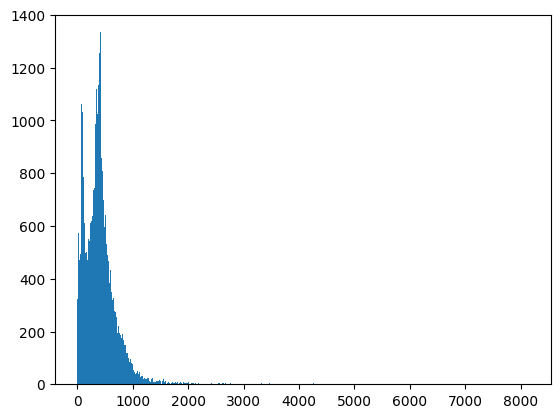

In [52]:
plt.hist([len(x) for x  in X],bins=700)
plt.show()

In [53]:
nos = np.array([len(x) for x  in X])
len(nos[nos>1000])

1584

In [54]:
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

In [55]:
len(X[101])

1000

In [56]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [57]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size,DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [58]:
vocab_size

230855

In [59]:
embedding_vectors = get_weight_matrix(w2v_model)

In [60]:
embedding_vectors.shape

(230855, 100)

In [61]:
print(f"vocab_size: {vocab_size}, DIM: {DIM}, maxlen: {maxlen}")
print(f"embedding_vectors shape: {embedding_vectors.shape}")

vocab_size: 230855, DIM: 100, maxlen: 1000
embedding_vectors shape: (230855, 100)


In [73]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors],
                    input_shape=(maxlen,), trainable=False))
model.add(LSTM(units=128, input_shape=(maxlen, DIM)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1000, 100)           │      23,085,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,202,877 (88.51 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 23,085,500 (88.06 MB)

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [76]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - acc: 0.9100 - loss: 0.2271 - val_acc: 0.9669 - val_loss: 0.0988
Epoch 2/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - acc: 0.9694 - loss: 0.0904 - val_acc: 0.9771 - val_loss: 0.0712
Epoch 3/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - acc: 0.9677 - loss: 0.0883 - val_acc: 0.9622 - val_loss: 0.1111
Epoch 4/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - acc: 0.9792 - loss: 0.0598 - val_acc: 0.9827 - val_loss: 0.0538
Epoch 5/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - acc: 0.9895 - loss: 0.0308 - val_acc: 0.9824 - val_loss: 0.0561
Epoch 6/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - acc: 0.9906 - loss: 0.0294 - val_acc: 0.9854 - val_loss: 0.0472


In [77]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [78]:
accuracy_score(y_test,y_pred)

0.9876169265033408

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.98      0.99      0.99      5302

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [80]:
x = ['this is a news']

In [81]:
X_test

array([[     0,      0,      0, ...,  37554,    197, 211166],
       [     0,      0,      0, ...,     19,    212,  34805],
       [     0,      0,      0, ...,    528,   4095,  11527],
       ...,
       [     0,      0,      0, ...,     25,     40,    267],
       [     0,      0,      0, ...,    175,   1097,     93],
       [     0,      0,      0, ...,  26883,      3,   8101]], dtype=int32)

In [82]:
x = ['Shocking! Michele Obama & Hillary Caught Glamorizing Date Rape Promoters']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)

In [83]:
(model.predict(x) >=0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0]])